# Logistic Regression, Decision Tree and RandomForestClassifier with the Wisconsin Breast Cancer Dataset

In this section I will import the Wisconsin Breast Cancer Dataset from the UCI repository in order to predict car prices. I will do some preprocessing or cleaning of the data, scale the data to bring the range of data across all columns into a more appropriate range then run Logistic Regression, Decision Tree as well as Random Forest Classifier models. I will then compare the Training and Test set scores of each to determine whether or not there is overfitting, underfitting or if the scores for a particular model are ideal.

Lets import the required libraries along with the dataset from the UCI repositotry. For the read_csv function I will include the path to the data, the attribute names, set na_values parameter to ?, 0 and '' which indicates that for any columns whose values contain a question mark, zero or empty values within the specific column, those values will be replaced with a NAN as part of preprocessing the dataset. This will allow me to replace NAN with the mean value of each respective column.

In [99]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import numpy as np
path="https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"
columns = ['Sample code number','Clump Thickness ', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses', 'Class']
df = pd.read_csv(path, index_col = None, names=columns, na_values=['?', 0, ''])
df


,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1.00,3,1,1,2
1,1002945,5,4,4,5,7,10.00,3,2,1,2
2,1015425,3,1,1,1,2,2.00,3,1,1,2
3,1016277,6,8,8,1,3,4.00,3,7,1,2
4,1017023,4,1,1,3,2,1.00,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...
694,776715,3,1,1,1,3,2.00,1,1,1,2
695,841769,2,1,1,1,2,1.00,1,1,1,2
696,888820,5,10,10,3,7,3.00,8,10,2,4
697,897471,4,8,6,4,3,4.00,10,6,1,4


Lets run the info method on the dataframe to see the datatype of each column in the dataframe as well as the number of non-null values in each column.

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Sample code number           699 non-null    int64  
 1   Clump Thickness              699 non-null    int64  
 2   Uniformity of Cell Size      699 non-null    int64  
 3   Uniformity of Cell Shape     699 non-null    int64  
 4   Marginal Adhesion            699 non-null    int64  
 5   Single Epithelial Cell Size  699 non-null    int64  
 6   Bare Nuclei                  683 non-null    float64
 7   Bland Chromatin              699 non-null    int64  
 8   Normal Nucleoli              699 non-null    int64  
 9   Mitoses                      699 non-null    int64  
 10  Class                        699 non-null    int64  
dtypes: float64(1), int64(10)
memory usage: 60.2 KB


Now we need to drop the column attribute 'Sample code number' from the dataframe prior to completing any further data preprocessing.

In [101]:
df = df.drop(['Sample code number'], axis=1)
df

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,5,1,1,1,2,1.00,3,1,1,2
1,5,4,4,5,7,10.00,3,2,1,2
2,3,1,1,1,2,2.00,3,1,1,2
3,6,8,8,1,3,4.00,3,7,1,2
4,4,1,1,3,2,1.00,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...
694,3,1,1,1,3,2.00,1,1,1,2
695,2,1,1,1,2,1.00,1,1,1,2
696,5,10,10,3,7,3.00,8,10,2,4
697,4,8,6,4,3,4.00,10,6,1,4


Lets check how each column correlates with the target variable class. I will sort the order of the values in decending order. I am also going to set the decimal format to allow only 2 values to allow for clearer evaluation of the data.

In [102]:
pd.options.display.float_format = '{:,.2f}'.format
corr = df.corr()
corr['Class'].sort_values(ascending=False)

Class                         1.00
Bare Nuclei                   0.82
Uniformity of Cell Shape      0.82
Uniformity of Cell Size       0.82
Bland Chromatin               0.76
Clump Thickness               0.72
Normal Nucleoli               0.71
Marginal Adhesion             0.70
Single Epithelial Cell Size   0.68
Mitoses                       0.42
Name: Class, dtype: float64

Now lets check for all column attributes which are greater than or equal to 0.70 but less than 1. These are the features which at the end of our data analysis and preprocessing step will be run through the Machine Learning Models.

In [103]:
extracted_features = corr['Class'][(corr['Class'] >= 0.7) & (corr['Class'] < 1)]   
extracted_features   

Clump Thickness            0.72
Uniformity of Cell Size    0.82
Uniformity of Cell Shape   0.82
Bare Nuclei                0.82
Bland Chromatin            0.76
Normal Nucleoli            0.71
Name: Class, dtype: float64

Now with the understanding of the features above that we will keep let find the features that we want to drop from the dataframe. Lets start by finding the features that do not correlate with the price well by taking those less than 0.7 as well as those greater and that which is equal to 1. This will be the group of features we drop from the dataframe.

In [104]:
throwaway_features = corr['Class'][((corr['Class'] < 0.7) | (corr['Class'] == 1))]   
throwaway_features

Marginal Adhesion             0.70
Single Epithelial Cell Size   0.68
Mitoses                       0.42
Class                         1.00
Name: Class, dtype: float64

Here i will take the throw away features and turn them into a list to be dropped from the dataframe.

In [105]:
thf = throwaway_features.keys()
throw_list = thf.to_list()
throw_list

['Marginal Adhesion', 'Single Epithelial Cell Size', 'Mitoses', 'Class']

Also before going any further, lets see how many null values exist within each column of the dataset.

In [106]:
df.isnull().sum()

Clump Thickness                 0
Uniformity of Cell Size         0
Uniformity of Cell Shape        0
Marginal Adhesion               0
Single Epithelial Cell Size     0
Bare Nuclei                    16
Bland Chromatin                 0
Normal Nucleoli                 0
Mitoses                         0
Class                           0
dtype: int64

We can see that the Bare Nuclei attribute has 16 null values which we can take care of using the SimpleImputer class.

Next we will assign the contents of the price column which is the target or output value we are looking to predict to the y variable. The y variable will be used to train the Machine Learning models later on.

In [107]:
y = df['Class']
y

0      2
1      2
2      2
3      2
4      2
      ..
694    2
695    2
696    4
697    4
698    4
Name: Class, Length: 699, dtype: int64

Now I am going to use the describe method on the dataframe to get some statistical information from data such as the mean, standard deviation, min and max values within each column.

In [108]:
df.describe()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
count,699.00,699.00,699.00,699.00,699.00,683.00,699.00,699.00,699.00,699.00
mean,4.42,3.13,3.21,2.81,3.22,3.54,3.44,2.87,1.59,2.69
std,2.82,3.05,2.97,2.86,2.21,3.64,2.44,3.05,1.72,0.95
min,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,2.00
25%,2.00,1.00,1.00,1.00,2.00,1.00,2.00,1.00,1.00,2.00
50%,4.00,1.00,1.00,1.00,2.00,1.00,3.00,1.00,1.00,2.00
75%,6.00,5.00,5.00,4.00,4.00,6.00,5.00,4.00,1.00,4.00
max,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,4.00


Now we can use the list object throw_list to drop specific attributes seen as numerically unusaable from the dataset to allow for further preprocessing of the dataset. 

In [109]:
df.drop(throw_list, axis = 1,inplace=True)
df

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Bare Nuclei,Bland Chromatin,Normal Nucleoli
0,5,1,1,1.00,3,1
1,5,4,4,10.00,3,2
2,3,1,1,2.00,3,1
3,6,8,8,4.00,3,7
4,4,1,1,1.00,3,1
...,...,...,...,...,...,...
694,3,1,1,2.00,1,1
695,2,1,1,1.00,1,1
696,5,10,10,3.00,8,10
697,4,8,6,4.00,10,6


Since dataframe has null values, run Simple Imputer to replace null values in the Bare Nuclei column with the mean of that column.

In [110]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X = imp.fit_transform(df)



Since null values no longer exist above, now need to scale the data using the StandardScaler class so that the data ranges are not as varied.

In [111]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df2_scaled = scaler.fit_transform(X)
df2_scaled

array([[ 0.20693572, -0.69999505, -0.74329904, -0.70699139, -0.17966213,
        -0.61182504],
       [ 0.20693572,  0.28384518,  0.2668747 ,  1.79351268, -0.17966213,
        -0.28411186],
       [-0.50386559, -0.69999505, -0.74329904, -0.4291576 , -0.17966213,
        -0.61182504],
       ...,
       [ 0.20693572,  2.25152563,  2.28722218, -0.15132382,  1.87236122,
         2.33759359],
       [-0.14846494,  1.59563215,  0.94032386,  0.12650997,  2.69317056,
         1.02674087],
       [-0.14846494,  1.59563215,  1.61377302,  0.40434375,  2.69317056,
         0.37131451]])

Lets rebuild the dataframe from the numpy array above and then check the distribution of each attribute in the dataframe.

In [112]:
df2_scaled = pd.DataFrame(df2_scaled, columns=df.columns)
df2_scaled

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Bare Nuclei,Bland Chromatin,Normal Nucleoli
0,0.21,-0.70,-0.74,-0.71,-0.18,-0.61
1,0.21,0.28,0.27,1.79,-0.18,-0.28
2,-0.50,-0.70,-0.74,-0.43,-0.18,-0.61
3,0.56,1.60,1.61,0.13,-0.18,1.35
4,-0.15,-0.70,-0.74,-0.71,-0.18,-0.61
...,...,...,...,...,...,...
694,-0.50,-0.70,-0.74,-0.43,-1.00,-0.61
695,-0.86,-0.70,-0.74,-0.71,-1.00,-0.61
696,0.21,2.25,2.29,-0.15,1.87,2.34
697,-0.15,1.60,0.94,0.13,2.69,1.03


Now lets check the distribution of each of the attributes in the dataframe.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f25a6061290>,
      dtype=object)

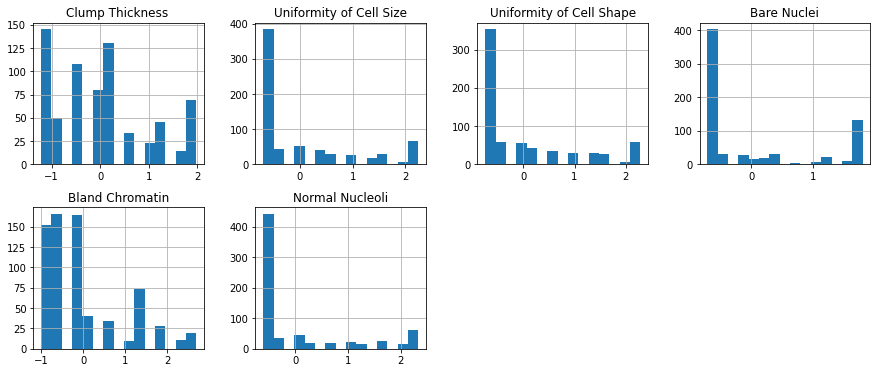

In [115]:
df2_scaled.hist(bins=15, figsize=(15,6), layout=(2,4))

Lets fit a Logistic Regression model

In [119]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
lr = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(df2_scaled, y, test_size=0.25, random_state=43)
lr.fit(X_train, y_train)
print("Training score", lr.score(X_train, y_train))
print("Test score", lr.score(X_test, y_test))

Training score 0.9713740458015268
Test score 0.9428571428571428


Now fit a Decision Tree model 

In [121]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
tr  = DecisionTreeClassifier(max_depth=4)
X_train, X_test, y_train, y_test = train_test_split(df2_scaled, y, test_size=0.25, random_state=43)
tr.fit(X_train, y_train)
print("Training score", tr.score(X_train, y_train))
print("Test score", tr.score(X_test, y_test))

Training score 0.9809160305343512
Test score 0.9371428571428572


Lastly, lets try a RandomForestClassifier

In [124]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
rfc  = RandomForestClassifier()
X_train, X_test, y_train, y_test = train_test_split(df2_scaled, y, test_size=0.25, random_state=43)
rfc.fit(X_train, y_train)
print("Training score", tr.score(X_train, y_train))
print("Test score", tr.score(X_test, y_test))


Training score 0.9809160305343512
Test score 0.9371428571428572
